> Анализ результатов A/B-теста по проверке эффективности системы рекомендаций в приложении доставки

В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
from scipy.stats import chi2_contingency, chi2 

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [2]:
users_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-chepel/module_stat/ab_users_data.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-chepel/module_stat/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-chepel/module_stat/ab_products.csv')

In [5]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [6]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


#### Метрики, отвечающие за эффективность системы рекомендаций:
1. Среднее кол-во заказов
2. Среднее кол-во продуктов в заказе

#### Проверим первую метрику – cреднее кол-во заказов.

In [7]:
df1 = users_data.groupby(['user_id', 'group'], as_index=False).agg({'order_id':'nunique'}).rename(columns={'order_id':'order_count'})
df1

,user_id,group,order_count
0,964,0,2
1,965,1,9
2,966,0,1
3,967,1,5
4,968,0,3
...,...,...,...
1012,1976,1,5
1013,1977,1,4
1014,1978,1,7
1015,1979,1,6


Сравним среднее кол-во заказов в группах с помощью стат. теста. 

##### Сначала проверим требование о нормальности распределений.
Проведем тест Д'Агостино-Пирсона.

H0: Распределение значимо не отличается от нормального.

In [8]:
ss.normaltest(df1[df1.group == 0].order_count)

NormaltestResult(statistic=168.68174543124155, pvalue=2.350847085591091e-37)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


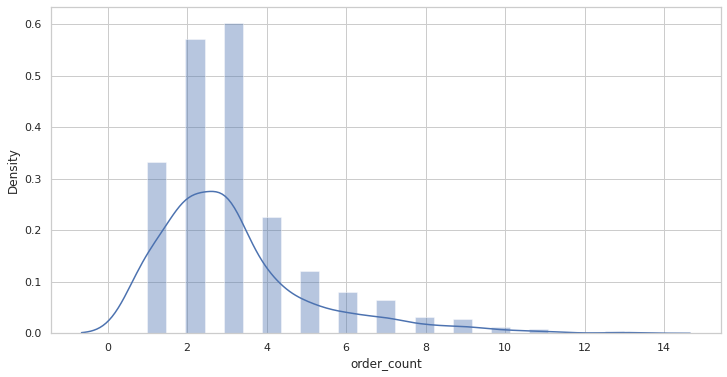

In [9]:
sns.distplot(df1[df1.group == 0].order_count)

In [10]:
ss.normaltest(df1[df1.group == 1].order_count)

NormaltestResult(statistic=21.897130007276793, pvalue=1.7583229075690624e-05)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


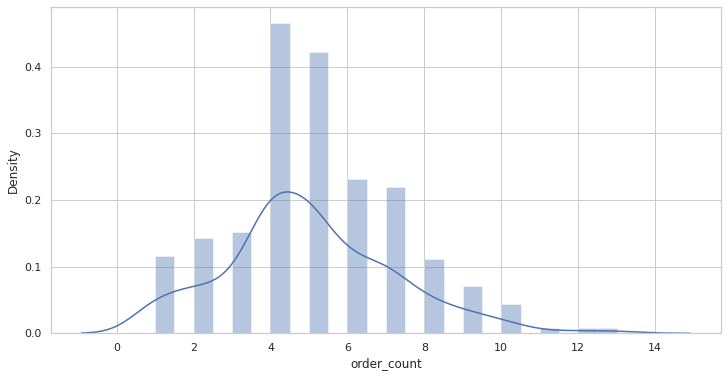

In [11]:
sns.distplot(df1[df1.group == 1].order_count)

Т.к. в обоих случаях pvalue < 0.05, делаем вывод что в обеих группах распределение отличается от нормального.

##### В качестве предобработки данных проведем логарифмирование, чтобы сделать распределение более симметричным.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


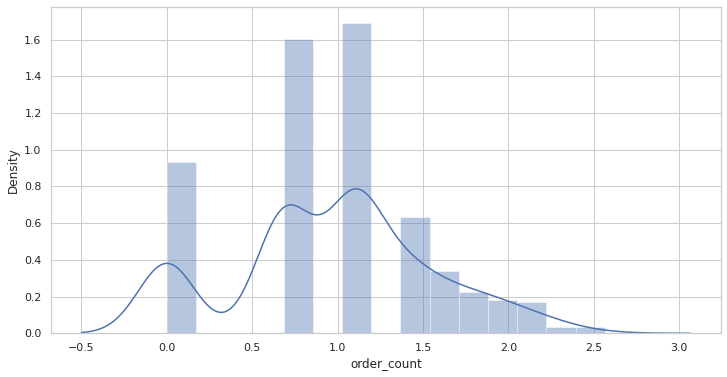

In [12]:
sns.distplot(np.log(df1[df1.group == 0].order_count))

In [13]:
ss.normaltest(np.log(df1[df1.group == 0].order_count))

NormaltestResult(statistic=2.8976671269212666, pvalue=0.23484405908608394)

В нулевой группе после логарифмирования распределение значимо не отличается от нормального (pvalue > 0.05).

Прологарифмируем данные 1-й группы.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


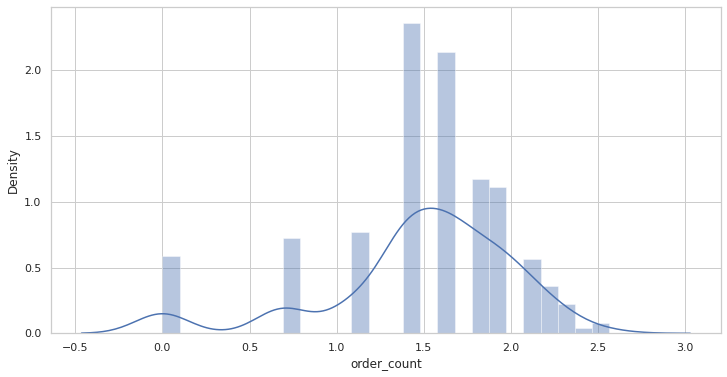

In [14]:
sns.distplot(np.log(df1[df1.group == 1].order_count))

In [15]:
ss.normaltest(np.log(df1[df1.group == 1].order_count))

NormaltestResult(statistic=88.67441302085199, pvalue=5.553872040481577e-20)

В первой группе после логарифмирования распределение все еще значимо отличается от нормального (pvalue < 0.05), так как изначально распределение не было сильно асимметричным.

##### Проверим требование о гомогенности дисперсий.

Проведем тест Левена.

H0: Дисперсии внутри групп примерно одинаковы.

In [16]:
ss.levene(df1[df1.group == 0].order_count, df1[df1.group == 1].order_count)

LeveneResult(statistic=16.167730257365115, pvalue=6.226688002409379e-05)

Т.к. pvalue < 0.05, отклоняем нулевую гипотезу, дисперсии в группах различаются.

##### Используем непараметрический критерий Манна-Уитни (распределение отличается от нормального, дисперсии в группах различны, и сравниваем только 2 группы).

H0: В сравниваемых группах отсутствует различие в распределении частот.

In [17]:
ss.mannwhitneyu(df1[df1.group == 0].order_count, df1[df1.group == 1].order_count, alternative='two-sided') 

MannwhitneyuResult(statistic=61172.5, pvalue=6.987139829766148e-49)

pvalue < 0.05 => различия в группах статистически значимы.  

##### Поскольку наши выборки содержат значительно больше 30 наблюдений, можно также проверить гипотезу о равенстве средних с помощью t-теста. Т.к. дисперсии в выборках различаются, следует выполнить t-критерий Уэлча.

H0: В сравниваемых группах средние не различаются.

In [38]:
ss.ttest_ind(df1[df1.group == 0].order_count, df1[df1.group == 1].order_count, equal_var=False)

Ttest_indResult(statistic=-14.485156769858916, pvalue=2.9077831935473898e-43)

pvalue < 0.05 => Отвергаем нулевую гипотезу. t-тест подтвердил, что различия средних стат. значимы.

In [18]:
df1[df1.group == 0].order_count.mean()

3.124271844660194

In [19]:
df1[df1.group == 1].order_count.mean()

5.00796812749004

#### Среднее значение количества заказов статистически значимо увеличилось в группе, пользовавшейся приложением с системой рекомендации товаров.

#### Проверим вторую метрику – cреднее кол-во продуктов в заказе.

In [20]:
df2 = users_data.merge(orders, on='order_id')

In [21]:
df2.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"


In [22]:
# Рассчитываем кол-во продуктов в каждом заказе
df2['product_ids'] = df2.product_ids.apply(lambda x: x.replace('{', '').replace('}', '').split(', '))
df2['product_count'] = df2.product_ids.apply(lambda x: len(x))

Сравним среднее кол-во продуктов в заказах в двух группах с помощью стат. теста. 
##### Сначала проверим распределение на нормальность.

H0: Распределение значимо не отличается от нормального.

In [23]:
ss.normaltest(df2[df2.group == 0].product_count)

NormaltestResult(statistic=38.81416091539066, pvalue=3.72916884568732e-09)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


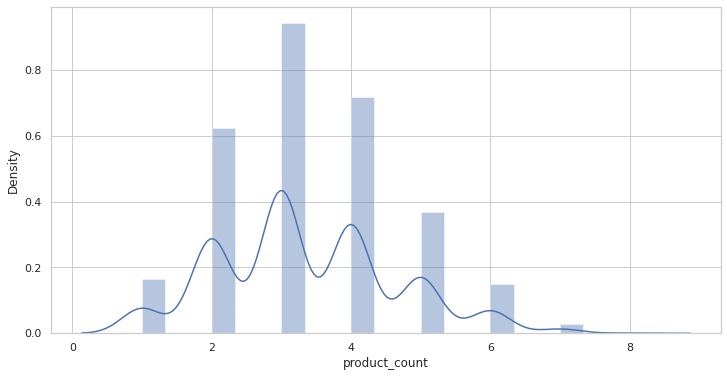

In [24]:
sns.distplot(df2[df2.group == 0].product_count)

In [25]:
ss.normaltest(df2[df2.group == 1].product_count)

NormaltestResult(statistic=51.21178551165087, pvalue=7.577083477434768e-12)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


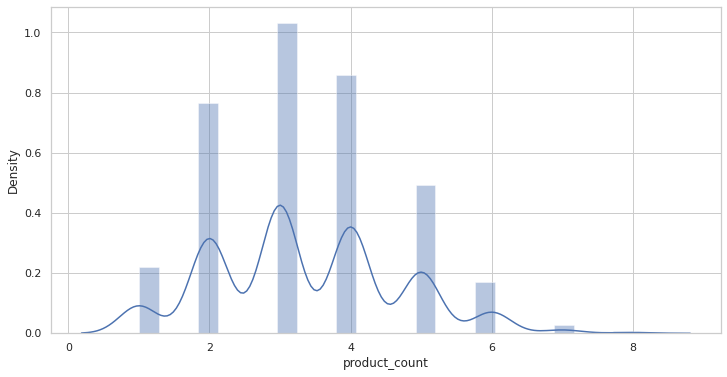

In [26]:
sns.distplot(df2[df2.group == 1].product_count)

В обеих группах распределение отличается от нормального, так как pvalue < 0.05. 

По графикам можно сделать вывод, что распределения не обладают выраженной асимметричностью и логирифмирование не поможет привести их к нормальному виду.

##### Проверим требование о гомогенности дисперсий.

H0: Дисперсии внутри групп примерно одинаковы.

In [34]:
ss.levene(df2[df2.group == 0].product_count, df2[df2.group == 1].product_count)

LeveneResult(statistic=2.4198112893147674, pvalue=0.1198823607548248)

Т.к. pvalue > 0.05, принимаем нулевую гипотезу, дисперсии в группах примерно одинаковы.

##### Используем непараметрический критерий Манна-Уитни (распределение отличается от нормального, и сравниваем только 2 группы).

H0: В сравниваемых группах отсутствует различие в распределении частот.

In [28]:
ss.mannwhitneyu(df2[df2.group == 0].product_count, df2[df2.group == 1].product_count, alternative='two-sided') 

MannwhitneyuResult(statistic=2231494.0, pvalue=0.8842577601248963)

pvalue > 0.05 => Различия в группах статистически незначимы.

##### Поскольку наши выборки содержат значительно больше 30 наблюдений, а дисперсии одинаковы, можно также проверить гипотезу о равенстве средних с помощью t-теста.

H0: В сравниваемых группах средние не различаются.

In [35]:
ss.ttest_ind(df2[df2.group == 0].product_count, df2[df2.group == 1].product_count)

Ttest_indResult(statistic=-0.08294930115365474, pvalue=0.9338956822202736)

pvalue > 0.05 => Тест подтвердил, что различия средних значений стат. незначимы.

#### Нет статистически значимых изменений в среднем количестве продуктов в заказах в двух группах.

### Вывод: 
Несмотря на то, что кол-во продуктов в заказах не увеличилось значимо, следует включить новую систему рекомендаций, так как значимое увеличение среднего количества заказов свидетельствует о том, что приложение стало удобнее для пользователей. Но стоит подумать над тем, как увеличить количество продуктов в заказах, чтобы увеличивать не только средний чек с пользователя, но и с каждого заказа.